In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from google.colab import drive

In [ ]:
class ModelSelectionEnvironment:
  def __init__(self, X_train, X_test, y_train, y_test):
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test

    # Available models with more diverse configurations
    self.models = {
        0: ('Naive Bayes', GaussianNB()),
        1: ('Logistic Regression', LogisticRegression(max_iter=1000)),
        2: ('SVM Linear', SVC(kernel='linear')),
        3: ('SVM RBF', SVC(kernel='rbf')),
        4: ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
        5: ('Random Forest', RandomForestClassifier(n_estimators=50)),
        6: ('KNN k=5', KNeighborsClassifier(n_neighbors=6))
        }

    self.state_size = 4  # [accuracy, precision, recall, f1]
    self.action_size = len(self.models)
    self.reset()

  def reset(self):
    # Initialize state with zeros or random values
    self.current_state = np.random.rand(4)
    return self.current_state

  def step(self, action):
    # Get the selected model
    model_name, model = self.models[action]

    # Train and predict
    model.fit(self.X_train, self.y_train)
    y_pred = model.predict(self.X_test)

    # Calculate metrics
    metrics = np.array([
        accuracy_score(self.y_test, y_pred),
        precision_score(self.y_test, y_pred, average='weighted'),
        recall_score(self.y_test, y_pred, average='weighted'),
        f1_score(self.y_test, y_pred, average='weighted')
        ])

    # Calculate a more nuanced reward
    reward = np.mean(metrics)
    # Add a penalty for complexity
    complexity_penalty = 1 / (action + 1)  # Favor simpler models slightly
    reward *= complexity_penalty
    return metrics, reward, True, {'metrics': metrics, 'model_name': model_name}

In [ ]:
class EpsilonGreedyAgent:
  def __init__(self, action_size, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
    self.action_size = action_size
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = epsilon_min
    self.q_values = np.zeros(action_size)
    self.best_metrics = {'score': 0, 'model': None, 'metrics': None}
    self.action_history = []

  def act(self, state):
    # Exploration-exploitation trade-off
    if random.random() < self.epsilon:
      action = random.randrange(self.action_size)
    else:
      action = np.argmax(self.q_values)
    self.action_history.append(action)
    return action

  def learn(self, action, reward):
    # Update Q-values
    self.q_values[action] = max(self.q_values[action], reward)

    # Decay epsilon
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay

In [ ]:
class QLearningAgent:
  def __init__(self, state_size, action_size, learning_rate=0.1, gamma=0.9,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
    self.state_size = state_size
    self.action_size = action_size
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = epsilon_min
    self.q_table = {}
    self.best_metrics = {'score': 0, 'model': None, 'metrics': None}
    self.action_history = []

  def discretize_state(self, state):
    # More precise state discretization
    return tuple((state * 100).astype(int))

  def act(self, state):
    # Discretize the state for Q-table lookup
    discrete_state = self.discretize_state(state)

    # Initialize Q-values for this state if not exists
    if discrete_state not in self.q_table:
      self.q_table[discrete_state] = np.zeros(self.action_size)

    # Exploration-exploitation
    if random.random() < self.epsilon:
      action = random.randrange(self.action_size)
    else:
      action = np.argmax(self.q_table[discrete_state])

    self.action_history.append(action)
    return action

  def learn(self, state, action, reward, next_state):
    discrete_state = self.discretize_state(state)
    discrete_next_state = self.discretize_state(next_state)

    # Initialize Q-values for next state if not exists
    if discrete_next_state not in self.q_table:
      self.q_table[discrete_next_state] = np.zeros(self.action_size)

    # Q-learning update rule
    old_value = self.q_table[discrete_state][action]
    next_max = np.max(self.q_table[discrete_next_state])

    new_value = (1 - self.learning_rate) * old_value + \
                    self.learning_rate * (reward + self.gamma * next_max)

    self.q_table[discrete_state][action] = new_value

    # Decay epsilon
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay

In [ ]:
def train_and_evaluate(env, agent, episodes):
  results = []

  for episode in range(episodes):
    # Reset environment
    state = env.reset()

    # Select action
    action = agent.act(state)

    # Take step in environment
    next_state, reward, done, info = env.step(action)

    # Learn from the experience
    if isinstance(agent, EpsilonGreedyAgent):
      agent.learn(action, reward)
    else:  # Q-Learning
      agent.learn(state, action, reward, next_state)

    # Update best metrics
    metrics = info['metrics']
    score = np.mean(metrics)
    if score > agent.best_metrics['score']:
      agent.best_metrics = {
          'score': score,
          'model': info['model_name'],
          'metrics': metrics
          }

    # Store results
    results.append({
        'episode': episode,
        'model': info['model_name'],
        'accuracy': metrics[0],
        'precision': metrics[1],
        'recall': metrics[2],
        'f1': metrics[3],
        'reward': reward,
        'epsilon': agent.epsilon
        })

    # Occasional status update
    if episode % 10 == 0:
      print(f"Episode {episode}")
      print(f"Selected Model: {info['model_name']}")
      print(f"Metrics - Accuracy: {info['metrics'][0]:.4f}, Precision: {info['metrics'][1]:.4f}, Recall: {info['metrics'][2]:.4f}, F1: {info['metrics'][3]:.4f}, Reward: {reward:.4f}")
      print(f"Epsilon: {agent.epsilon:.4f}\n")

  return pd.DataFrame(results)

In [ ]:
def plot_comparison(results_dict):
  metrics = ['accuracy', 'precision', 'recall', 'f1', 'reward']
  fig, axes = plt.subplots(len(metrics), 1, figsize=(15, 4*len(metrics)), squeeze=False)

  for i, metric in enumerate(metrics):
    for algorithm, results in results_dict.items():
      axes[i, 0].plot(results['episode'], results[metric], label=algorithm)
      axes[i, 0].set_title(f'{metric.capitalize()} Over Episodes')
      axes[i, 0].set_xlabel('Episode')
      axes[i, 0].set_ylabel(metric.capitalize())
      axes[i, 0].legend()

  plt.tight_layout()
  plt.show()

In [ ]:
def main():
  # Load and prepare data
  drive.mount('/content/drive')
  # Path to your CSV file
  file_path = '/content/drive/My Drive/heart_disease.csv'
    # Load and prepare data
  df = pd.read_csv(file_path)
  X = df.drop('target', axis=1)
  y = df['target']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # Create environment
  env = ModelSelectionEnvironment(X_train, X_test, y_train, y_test)

  # Train all agents
  agents = {
      'epsilon_greedy': EpsilonGreedyAgent(env.action_size),
      'q_learning': QLearningAgent(env.state_size, env.action_size)
      }

  results = {}
  episodes = 100

  for name, agent in agents.items():
    print(f"\nTraining {name.upper()} agent...")
    results[name] = train_and_evaluate(env, agent, episodes)

  # Plot comparison
  plot_comparison(results)

  # Print final results
  print("\nFinal Results:")
  for name, agent in agents.items():
    print(f"\n{name.upper()} Best Model:")
    print(f"Model: {agent.best_metrics['model']}")
    metrics = agent.best_metrics['metrics']
    print(f"Accuracy: {metrics[0]:.4f}")
    print(f"Precision: {metrics[1]:.4f}")
    print(f"Recall: {metrics[2]:.4f}")
    print(f"F1 Score: {metrics[3]:.4f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Training EPSILON_GREEDY agent...
Episode 0
Selected Model: SVM RBF
Metrics - Accuracy: 0.8361, Precision: 0.8361, Recall: 0.8361, F1: 0.8361, Reward: 0.2090
Epsilon: 0.9950

Episode 10
Selected Model: Logistic Regression
Metrics - Accuracy: 0.8361, Precision: 0.8361, Recall: 0.8361, F1: 0.8361, Reward: 0.4180
Epsilon: 0.9464

Episode 20
Selected Model: Logistic Regression
Metrics - Accuracy: 0.8361, Precision: 0.8361, Recall: 0.8361, F1: 0.8361, Reward: 0.4180
Epsilon: 0.9001

Episode 30
Selected Model: Naive Bayes
Metrics - Accuracy: 0.8525, Precision: 0.8524, Recall: 0.8525, F1: 0.8522, Reward: 0.8524
Epsilon: 0.8561

Episode 40
Selected Model: SVM Linear
Metrics - Accuracy: 0.8525, Precision: 0.8524, Recall: 0.8525, F1: 0.8522, Reward: 0.2841
Epsilon: 0.8142

Episode 50
Selected Model: Logistic Regression
Metrics - Accuracy: 0.8361, Precision: 0.8361, Rec

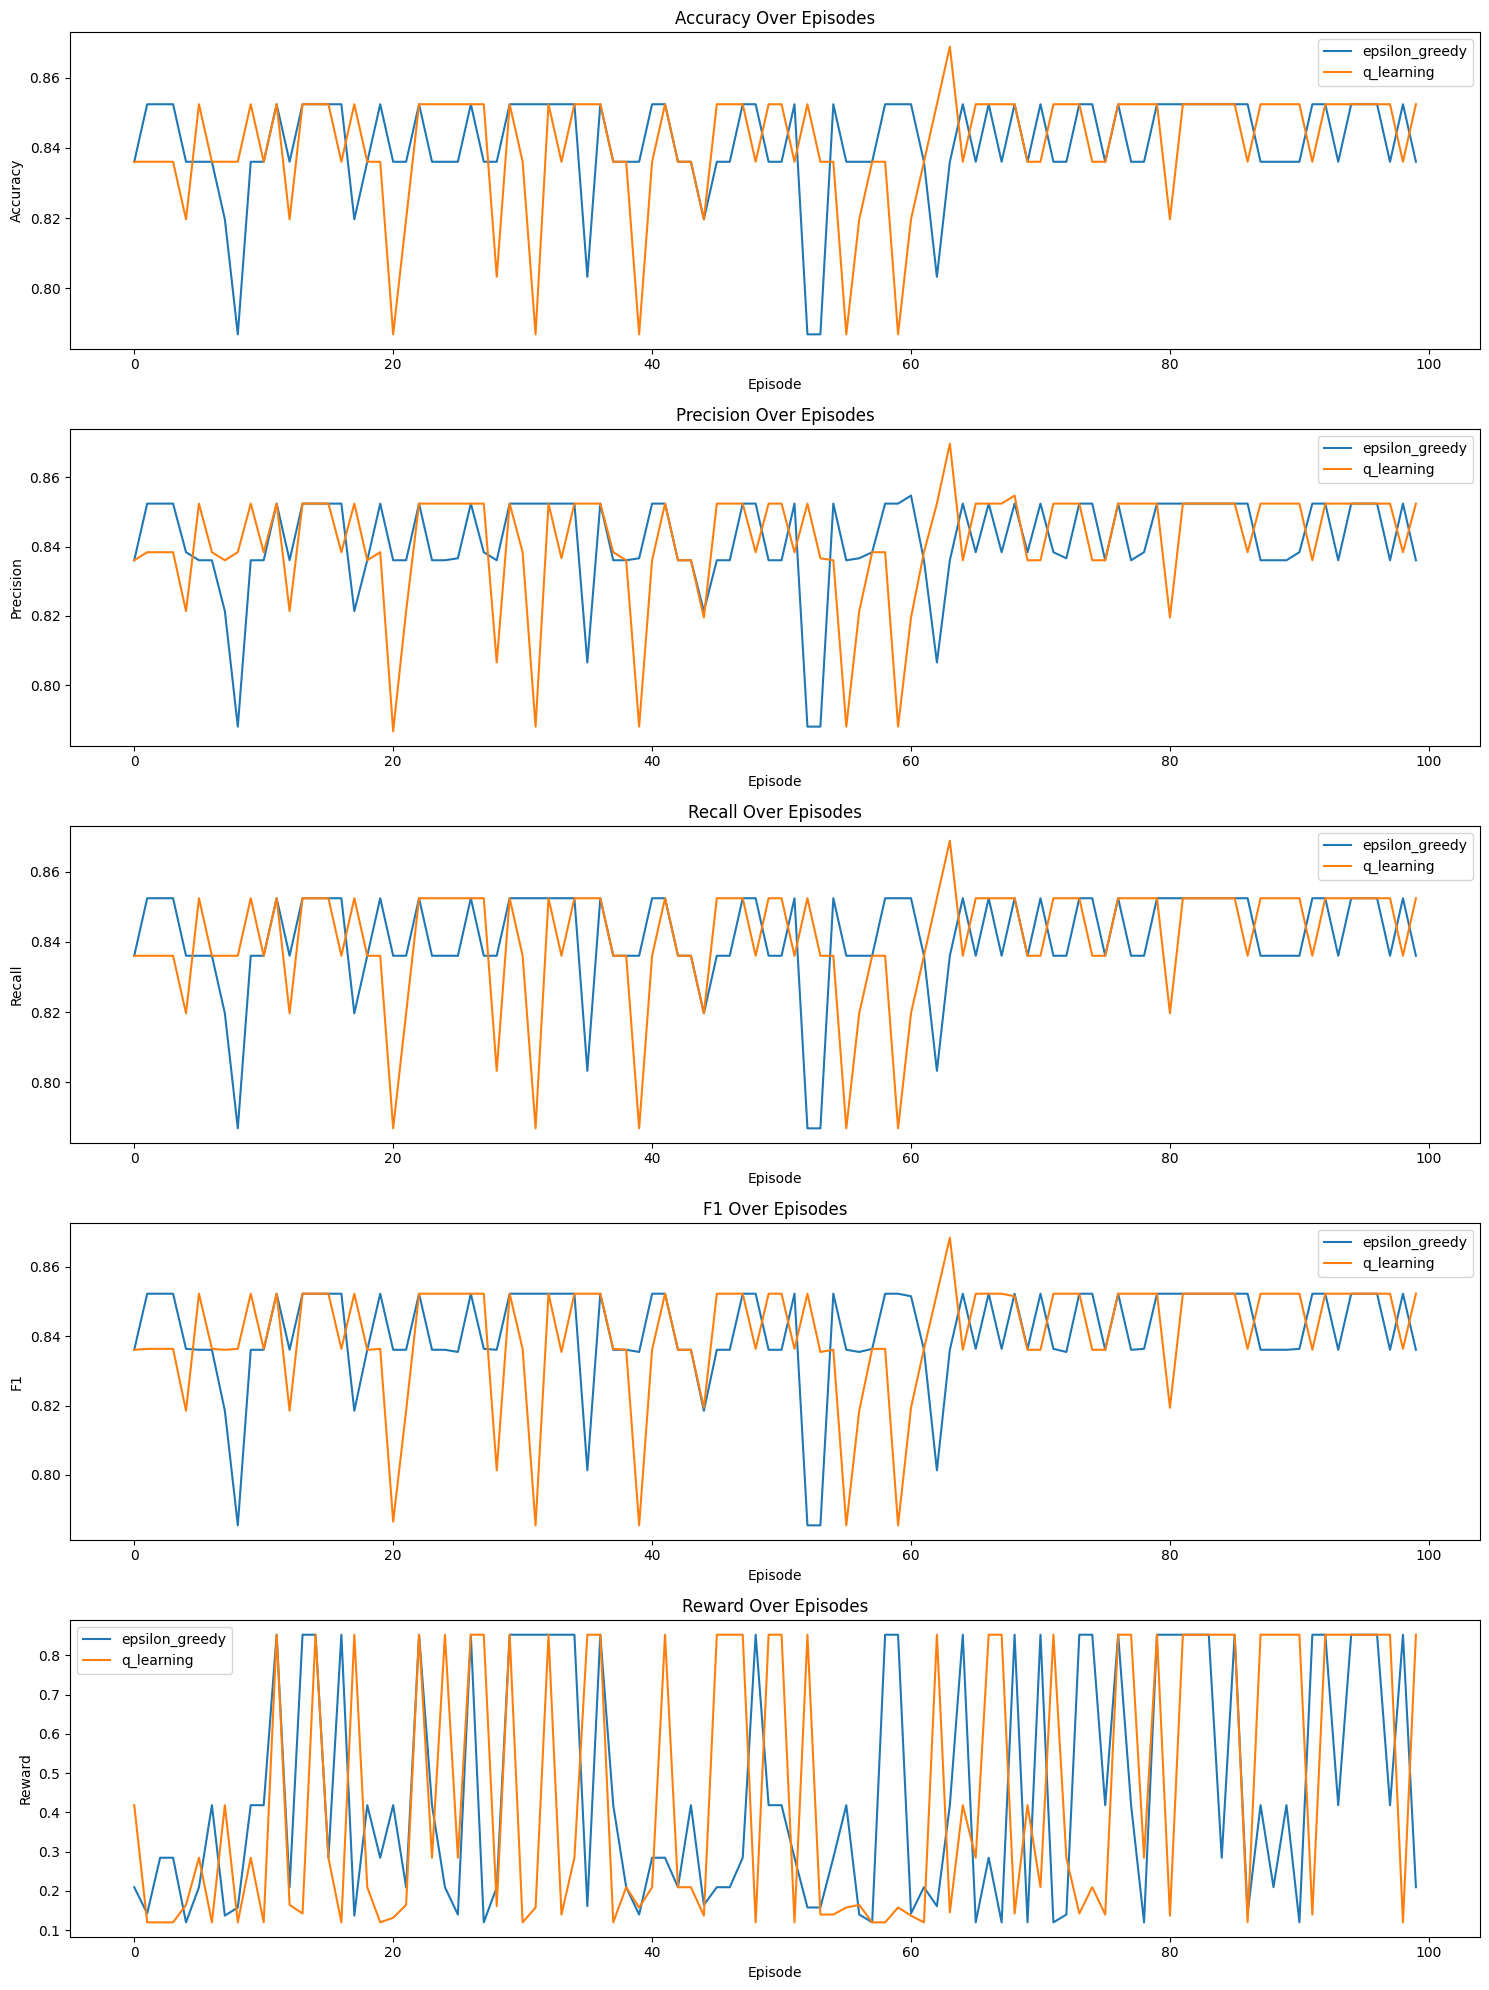


Final Results:

EPSILON_GREEDY Best Model:
Model: Random Forest
Accuracy: 0.8525
Precision: 0.8548
Recall: 0.8525
F1 Score: 0.8515

Q_LEARNING Best Model:
Model: Random Forest
Accuracy: 0.8689
Precision: 0.8698
Recall: 0.8689
F1 Score: 0.8684


In [ ]:
if __name__ == "__main__":
  main()